In [231]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# import functions
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA



# change settings for plots
plt.style.use('fivethirtyeight')

In [161]:
# write plotting functions to be used later



# 1) Load and Clean Data

Marketing campaigns (Call to Action) can be of any kind.

For example, a discount, getting something for free, collecting points on a membership card, free delivery, additional credit line, etc.

In this case, the type of campaign doesn't matter. What matters - is that different types of campaigns work better for specific clusters of customers.

In [162]:
data = pd.read_csv('/Users/alitaimurshabbir/Desktop/CRM Analytics Datasets/marketing_campaign.csv', sep = ';')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


## 1.1) Description of Columns

- AcceptedCmp1 - 1 if customer accepted the offer in the 1st campaign, 0 otherwise

- AcceptedCmp2 - 1 if customer accepted the offer in the 2nd campaign, 0 otherwise

- AcceptedCmp3 - 1 if customer accepted the offer in the 3rd campaign, 0 otherwise

- AcceptedCmp4 - 1 if customer accepted the offer in the 4th campaign, 0 otherwise

- AcceptedCmp5 - 1 if customer accepted the offer in the 5th campaign, 0 otherwise

- Response (target) - 1 if customer accepted the offer in the last campaign, 0 otherwise

- Complain - 1 if customer complained in the last 2 years

- DtCustomer - date of customer’s enrolment with the company

- Education - customer’s level of education

- Marital - customer’s marital status

- Kidhome - number of small children in customer’s household

- Teenhome - number of teenagers in customer’s household

- Income - customer’s yearly household income

- MntFishProducts - amount spent on fish products in the last 2 years

- MntMeatProducts - amount spent on meat products in the last 2 years

- MntFruits - amount spent on fruits products in the last 2 years

- MntSweetProducts - amount spent on sweet products in the last 2 years

- MntWines - amount spent on wine products in the last 2 years

- MntGoldProds - amount spent on gold products in the last 2 years

- NumDealsPurchases - number of purchases made with discount

- NumCatalogPurchases - number of purchases made using catalogue

- NumStorePurchases - number of purchases made directly in stores

- NumWebPurchases - number of purchases made through company’s web site

- NumWebVisitsMonth - number of visits to company’s web site in the last month

- Recency - number of days since the last purchase

## 1.2) Check for Duplicates

In [163]:
sum(data['ID'].duplicated())

0

Using the unique identifier "ID", we find no duplicates

## 1.3) Find and deal with missing data

In [164]:
missing_percent = (data.isnull().sum().sum()/np.product(data.shape))*100
print('The proportion of missing data on a cell-by-cell basis is {}%'.format(missing_percent))

The proportion of missing data on a cell-by-cell basis is 0.03694581280788178%


The amount of data missing is miniscule. We can isolate which column has this missing data then drop those rows. This will not impact the quality of the dataset since, as stated, there's very few rows that are empty

In [165]:
data.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [166]:
# drop rows where "Income" is missing data

data = data[data['Income'].notna()]

## 1.4) Check for extreme values that could be erroneous

In [167]:
data.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.0,2216.0,2216.000000
mean,5588.353339,1968.820397,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,...,5.319043,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,3.0,11.0,0.150271
std,3249.376275,11.985554,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,...,2.425359,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.0,0.0,0.357417
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2814.750000,1959.000000,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8421.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


There do not seem to be any obviously erroneous values. However, we see that the earliest year of birth in the data is 1893. This dataset is from 2014, making this particular customer 121 years old at the time of collection. Is this a valid record? It's possible but highly unlikely.

I will keep this record for now and, just for curiosity's sake, check how many customers are older than 90 years of age

In [168]:
# to be 90 years of age or more, a customer needs to be born in or before 1924 (2014-1924 = 90)

data[data['Year_Birth'] <= 1924]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
192,7829,1900,2n Cycle,Divorced,36640.0,1,0,2013-09-26,99,15,...,5,0,0,0,0,0,1,3,11,0
239,11004,1893,2n Cycle,Single,60182.0,0,1,2014-05-17,23,8,...,4,0,0,0,0,0,0,3,11,0
339,1150,1899,PhD,Together,83532.0,0,0,2013-09-26,36,755,...,1,0,0,1,0,0,0,3,11,0


# 2) Exploratory Data Analysis

## 2.1) Overall Conversion Rates (%), Cost Per Acquisition (CPA) and Profitability

We have a lot of data in terms of different variables. We even have conversion data from the last 5 Marketing Campaign (our most recent campaign is not included in this count. It is our target variable).

Segmenting and dissecting the data in every possible way will lead to an extremely long piece of analysis. Not all of the analysis will be valuable either. After all, we are only interested in insights that have the maximum business impact.

Therefore, to frame the analysis, I am going to restrict the scope to explore only the most recent Marketing Campaign. In addition, I will choose what I judge to be the most interesting and promising variables to explore insights.

### 2.11) Conversion Rate (%)

(array([], dtype=float64), [])

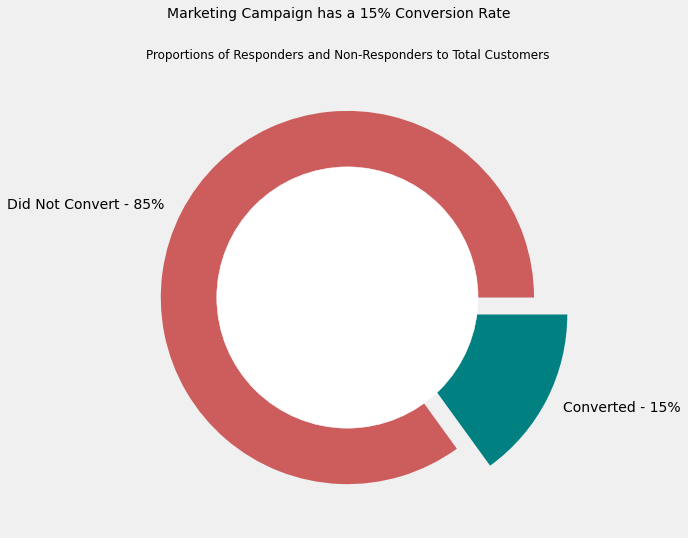

In [169]:
# find number of non-responders vs responders, then create donut plot

response_counts = data.Response.value_counts()

no_response = str(round(response_counts[0]/sum(response_counts)*100)) + '%'
yes_response = str(round(response_counts[1]/sum(response_counts)*100)) + '%'

# donut plot

explode = (0, 0.2)
plt.figure(figsize = (8, 8))
plt.pie(response_counts,
        labels = ['Did Not Convert' + ' - ' + no_response,
                  'Converted' + ' - ' + yes_response],
        explode = explode, 
        colors = ['indianred', 'teal'])

circle = plt.Circle((0,0), 0.7, color='white')

p = plt.gcf()
p.gca().add_artist(circle)

plt.suptitle('Marketing Campaign has a 15% Conversion Rate', size = 14)
plt.title('Proportions of Responders and Non-Responders to Total Customers', size = 12)
plt.xticks(size = 10)
plt.yticks(size = 10)


### 2.12) Cost Per Acquisition (CPA) and Profitability

The data shows us that the cost to contact a single customer is fixed at $3. We can use this information to calculate how profitable our marketing campaign was

In [170]:
# find profit or loss for each customer targted by campaign

conditions = [data['Response'] == 1, data['Response'] == 0]
outcomes = [8, -3]

data['Profit'] = np.select(conditions, outcomes)

For now we can find a simple total for how profitable our campaign was. Later we will segment profitability by customer characteristics to figure out which of our customers were the most and least valuable

In [171]:
print('The total Profit (+) or Loss (-) of our marketing campaign was {} USD'.format(sum(data['Profit'])))

The total Profit (+) or Loss (-) of our marketing campaign was -2985 USD


Clearly, this marketing campaign was a failure overall, as the business lost $2,985.

Now one of our main aims is to figure out which customers, grouped by characteristics, caused us to lose money (so we reconsider marketing to them in the future) and which customers were profitable (so we can target them more narrowly next time)

## 2.2) Income

Here I want to find out how conversion and profitability vary with customer Income.

To be able to do this, I will examine the distribution of the Income variable and create appropriate bins, then plot these against the customer responses

Text(0, 0.5, 'Density')

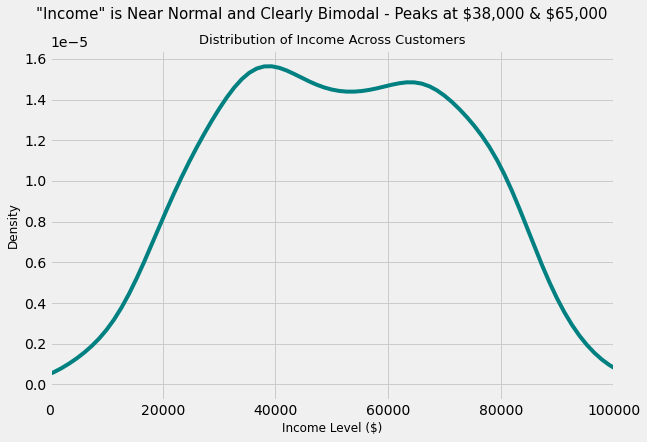

In [172]:
# Let's create a density plot for a smooth graph

plt.figure(figsize = (9, 6))
data['Income'].plot(kind = 'kde', color = 'teal')
plt.xlim([0, 100000])
plt.suptitle('"Income" is Near Normal and Clearly Bimodal - Peaks at \$38,000 & \$65,000', size = 15)
plt.title('Distribution of Income Across Customers', size = 13)
plt.xlabel('Income Level ($)', size = 12)
plt.ylabel('Density', size = 12)

This confirms that the Income variable is Bimodal

### 2.21) Number of Customer Conversions by Income Group

In [173]:
# Create deciles - 10 bins with "Income" variable equally divided

data['Income Deciles'] = pd.qcut(data.Income, q = 10, precision = 0)

The following graph shows the raw number of customer conversions segmented by income deciles (10 bins of customers by income). 

We can clearly see that 

- The greatest number of conversions are isolated to the two highest income deciles


- The fewest number of customers which were targeted by the marketing campaign also belong to the above two deciles

Text(0.5, 0, 'Number of Customers')

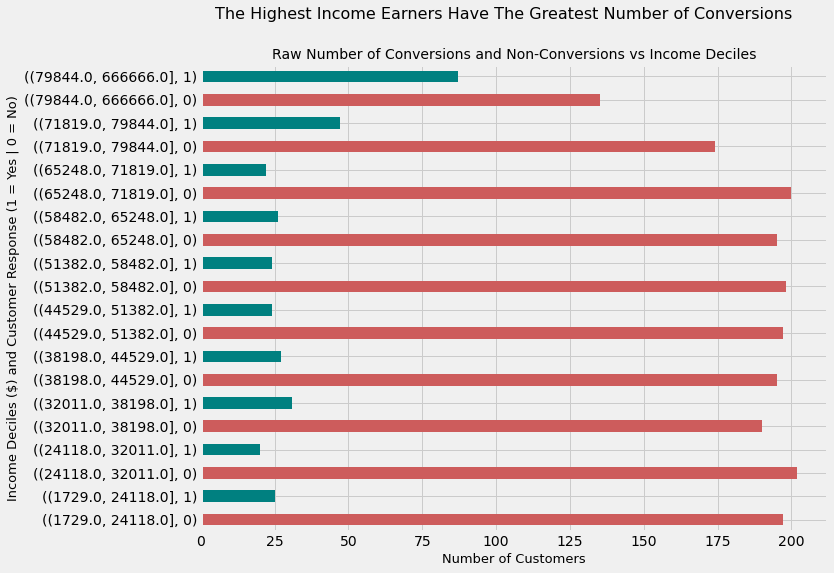

In [174]:
data.groupby('Income Deciles')['Response'].value_counts().plot(kind = 'barh',
                                                               color = ['indianred','teal'],
                                                               figsize = (10, 8))

plt.suptitle('The Highest Income Earners Have The Greatest Number of Conversions', size = 16)
plt.title('Raw Number of Conversions and Non-Conversions vs Income Deciles', size = 14)
plt.ylabel('Income Deciles ($) and Customer Response (1 = Yes | 0 = No)', size = 13)
plt.xlabel('Number of Customers', size = 13)

Above we calculated the raw number of conversions. But a much better measure is to figure out the rate of conversions, which we show below.

We see that with this measure, the highest income groups continue to be the most profitable customer segment when segmented by income

In [175]:
income_vs_conv = pd.crosstab(data['Income Deciles'], data['Response'])
income_vs_conv['Conversion Rate (%)'] = round((income_vs_conv[1]/(income_vs_conv[0] + income_vs_conv[1]))*100, 2)
income_vs_conv.sort_values(by = 'Conversion Rate (%)', ascending = False)

Response,0,1,Conversion Rate (%)
Income Deciles,,,
"(79844.0, 666666.0]",135,87,39.19
"(71819.0, 79844.0]",174,47,21.27
"(32011.0, 38198.0]",190,31,14.03
"(38198.0, 44529.0]",195,27,12.16
"(58482.0, 65248.0]",195,26,11.76
"(1729.0, 24118.0]",197,25,11.26
"(44529.0, 51382.0]",197,24,10.86
"(51382.0, 58482.0]",198,24,10.81
"(65248.0, 71819.0]",200,22,9.91


### 2.22) Marketing Campaign Profitability by Income Deciles

Text(0.5, 0, 'Profit/Loss ($)')

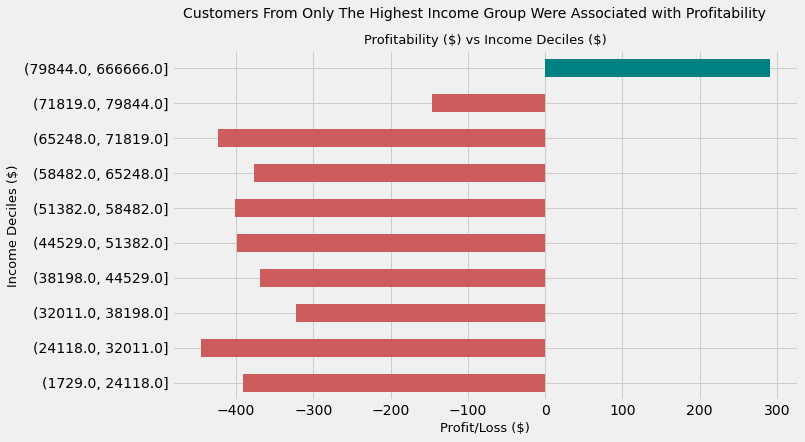

In [176]:
lc = 'indianred'
pc = 'teal'

data.groupby('Income Deciles')['Profit'].sum().plot(kind = 'barh',
                                                    color = [lc, lc,
                                                             lc, lc,
                                                             lc, lc,
                                                             lc, lc,
                                                             lc, pc],
                                                    figsize = (10, 6))


plt.suptitle('Customers From Only The Highest Income Group Were Associated with Profitability', size = 14)
plt.title('Profitability (\\$) vs Income Deciles (\\$)', size = 13)

plt.ylabel('Income Deciles ($)', size = 13)
plt.xlabel('Profit/Loss ($)', size = 13)

We have suffered losses in each and every single customer group except the highest incoming earning group when segmented by Income level. 

This latter group were responsible for \\$291 in profit. Conversely, the greatest loss was incurred in the second-to-lowest decile by Income which was approximately $450

**Takeaway**

This analysis seems to imply that the marketing campaign appeals the most to high income groups. They have the greatest conversion and, as a result, were the only profitable income group in the context of the marketing campaign.

If we run a future marketing campaign that is the same as this one, it could be a good idea to target high-income customers only, specifically those earning above $79,884 per year

## 2.3) Age and Education

Next I want to figure out the conversion rates and market campaign profitability when customers are segmented by Age and Education

Text(0, 0.5, 'Frequency')

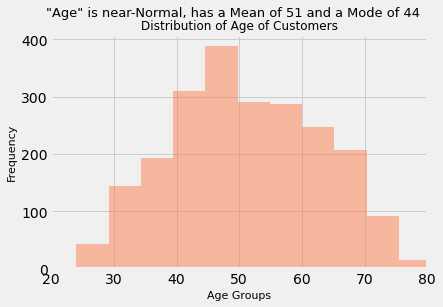

In [177]:
# Create "Age" variable and plot histogram

data['Age'] = 2020 - data['Year_Birth']
data['Age'].hist(bins = 20, color = 'coral', alpha = 0.5)
plt.xlim([20, 80])

plt.suptitle('"Age" is near-Normal, has a Mean of 51 and a Mode of 44', size = 13)
plt.title('Distribution of Age of Customers', size = 12)
plt.xlabel('Age Groups', size = 11)
plt.ylabel('Frequency', size = 11)

### 2.31) Conversion & Profitability by Age Group

In [178]:
# create Age bins. 
data['Age Bins'] = pd.cut(data['Age'],
                          bins = [24, 30, 40, # Youngest customer is 24 years old
                                  50, 60, 70,
                                  80, 120]) 

Text(0.5, 1.0, 'Conversion Percentage by Age Group')

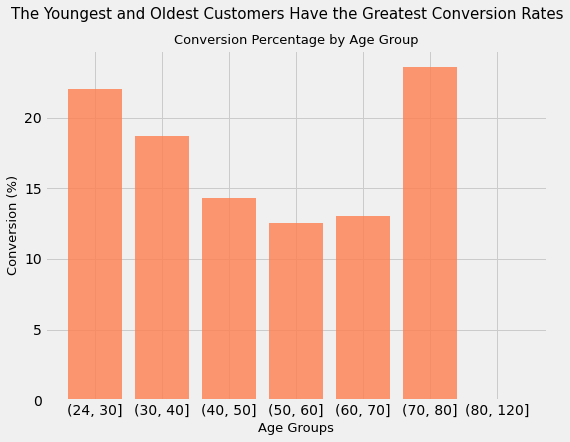

In [179]:
# plot conversion rates against age groups

age_conv_rate = pd.crosstab(data['Age Bins'], data['Response'])
age_conv_rate['Conversion %'] = round((age_conv_rate[1]/(age_conv_rate[0]+age_conv_rate[1]))*100, 2)

age_conv_rate.reset_index(inplace = True)
age_conv_rate['Age Bins'] = age_conv_rate['Age Bins'].astype(str)

plt.figure(figsize = (8, 6))
plt.bar(age_conv_rate['Age Bins'],
        age_conv_rate['Conversion %'],
        color = 'Coral',
        alpha = 0.8)

plt.xlabel('Age Groups', size = 13)
plt.ylabel('Conversion (%)', size = 13)
plt.suptitle('The Youngest and Oldest Customers Have the Greatest Conversion Rates', size = 15)
plt.title('Conversion Percentage by Age Group', size = 13)

Customers with ages in the intervals of 24-30 and 70-80 have the greatest conversion rates. For every 50 customers targeted with the marketing campaign in these age groups, more than 10 customers convert.

Conversely, middle-aged customers (those between 40 and 70 yeaes of age) have the worst conversion rate (between 12% and 14%)

In [180]:
youngest_and_oldest_customers = data.groupby('Age Bins')['ID'].count()[0] + data.groupby('Age Bins')['ID'].count()[5]

print('The total number of customers targeted belonging '
      'to the oldest and youngest age groups is {}'.format(youngest_and_oldest_customers))

The total number of customers targeted belonging to the oldest and youngest age groups is 165


Out of the total number of 2216 customers targeted in this ad campaign, 165 or about 7.5% belong to the age groups with the greatest conversion rates.

Now, we need to be careful with the conclusions we extract from this analysis. Larger sample sizes generally lead to more valid and accurate estimates. It is quite possible that if we were to target a larger sample size of only the oldest and youngest customers that the conversion percentages may drop from their current levels of > 20%, as the larger sample size will be more indicative of reality

Another way of saying this is that the youngest and oldest age groups might have such high conversion rates *because* there are very few of them compared to the whole customer base, and the small sample size might not be indicative of the ground truth


----

Now let's look at profitability

Text(0.5, 1.0, 'Marketing Campaign Profitability by Age Group')

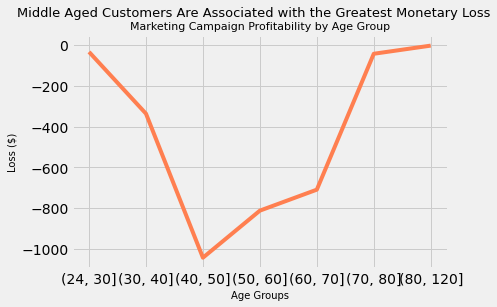

In [181]:
data.groupby('Age Bins')['Profit'].sum().plot(color = 'coral')
plt.ylabel('Loss ($)', size = 10)
plt.xlabel('Age Groups', size = 10)
plt.suptitle('Middle Aged Customers Are Associated with the Greatest Monetary Loss',
             size = 13)
plt.title('Marketing Campaign Profitability by Age Group', size = 11)

While we expected the groups with the worst conversion rates to not be profitable (middle aged customers), it is surprising to find that not a single group of customers, when segment by Age, proved to be profitable in our most recent Marketing Campaign.

Customers between 40 and 50 years have an associated loss of more than $1000. Interestingly, it is this same age group that has the greatest representation by raw numbers in the overall number of customers

What does this tell us in combination with the graph showing conversions? **It tells us that even in those Age Groups where the conversion rate is the highest, it is still not high enough for the marketing campaign to be profitable**

Therefore, targeting customers by age does not seem like a good idea for future marketing campaigns

### 2.32) Education

Text(0.5, 0, 'Loss ($)')

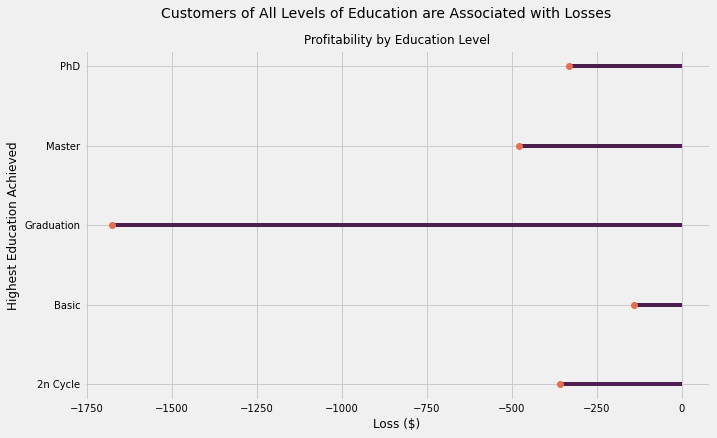

In [230]:
# find sum of profit per value of "Education"

education_vs_profit = data.groupby('Education')['Profit'].sum()

# create lollipop chart

plt.figure(figsize = (10, 6))

my_range = range(1,len(education_vs_profit.index)+1)
plt.hlines(y = education_vs_profit.index,
           xmin = 0 ,
           xmax = education_vs_profit,
           color='#4C1E4F')

plt.plot(education_vs_profit, education_vs_profit.index,
         "o", color = '#E76F51')

plt.xticks(size = 10)
plt.yticks(size = 10)
plt.suptitle('Customers of All Levels of Education are Associated with Losses',
             size = 14)
plt.title('Profitability by Education Level', size = 12)
plt.ylabel('Highest Education Achieved', size = 12)
plt.xlabel('Loss ($)', size = 12)

Much like the case with Age Groups, the "middle value" of Education, "Graduation" was related to the greatest loss incurred, reaching nearly -$1750. This suggests customers with this characteristic should not be targeted with this specific marketing campaign

## 2.4) Living Arrangements: Individual vs With Family

Let's consider:

- "Individuals" to be customers who are Single and have no children, and therefore do not live with them


- "With Family" to be customers who are either Single or Married but have at least 1 child or 1 teen living in the same house

(array([0, 1]), [Text(0, 0, 'Individual'), Text(0, 1, 'With Family')])

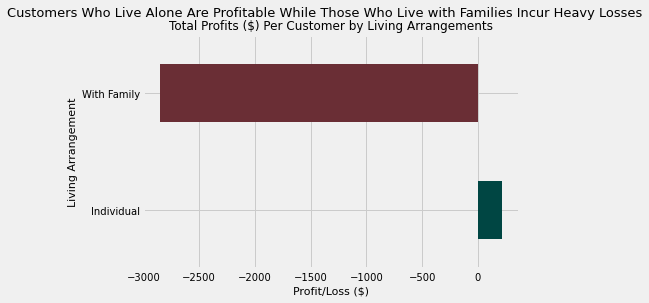

In [217]:
# create two dataframes to capture one group each

individuals = data.loc[(data['Marital_Status'] == 'Single') &
                       (data['Kidhome'] == 0) &
                       (data['Teenhome'] == 0)]

families = data.loc[(data['Kidhome'] == 1) |
                    (data['Teenhome'] == 1)]

# create a Series with the sum of Profit for above dataframes

ind_vs_family_profit = pd.Series([individuals.groupby('ID')['Profit'].sum().sum(),
                                  families.groupby('ID')['Profit'].sum().sum()],
                                  index = ['Individual', 'With Family'])

# plot

ind_vs_family_profit.plot(kind = 'barh', color = ['#004643', '#6A2E35'])
plt.suptitle('Customers Who Live Alone Are Profitable While Those Who Live with Families Incur Heavy Losses',
              size = 13)
plt.title('Total Profits ($) Per Customer by Living Arrangements',
          size = 12)
plt.xlabel('Profit/Loss ($)', size = 11)
plt.ylabel('Living Arrangement', size = 11)
plt.xticks(size = 10)
plt.yticks(size = 10)

(array([ 0., 10., 20., 30., 40., 50.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

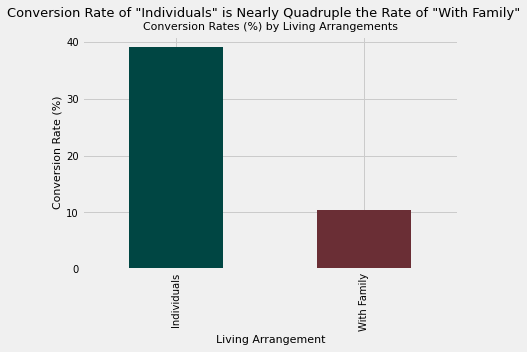

In [218]:
# plot conversion percentage 

ind_vs_family_conv = pd.Series([round((individuals.Response.sum()/len(individuals))*100, 2),
                                round((families.Response.sum()/len(families))*100, 2)],
                                index = ['Individuals', 'With Family'])

ind_vs_family_conv.plot(kind = 'bar', color = ['#004643', '#6A2E35'])
plt.suptitle('Conversion Rate of "Individuals" is Nearly Quadruple the Rate of "With Family"',
             size = 13)
plt.title('Conversion Rates (%) by Living Arrangements',
          size = 11)
plt.xlabel('Living Arrangement', size = 11)
plt.ylabel('Conversion Rate (%)', size = 11)
plt.xticks(size = 10)
plt.yticks(size = 10)

With nearly 4 times the conversion rate of customers who are considered to live "With Family", customers who live alone ("Individuals") are unsurprisingly associated with profitability (albeit a small profit) while the "With Family" group is associated with a loss of $2,700

---

So far we see that when we market to customers with the following characteristics, the marketing campaign is effective (as it is profitable):

- High-income customers, specifically those earning more than $79,000 annually


- Customers who live alone


This seems to imply that the marketing campaign is effective with wealthy bachelors and bachelorettes

## 2.5) Date of First Purchase (with some caveats)

I wonder if there is any relationship between the time elapsed between the date when a customer made their first purchase and the response rate. This isn't the best pair of measures to compare, but unfortunately we do not have other useful time-related data. This could be on, for example, the time elapsed since the *last* purchase, not the first one. So we will make do with what we have.

It is difficult to come up with a hypothesis before this analysis. For example, if we had data on every purchase a customer has made within a given timeframe, we could hypothesize that customers who made purchases with greater frequency in the last X number of days would be significantly more likely to convert due to the marketing campaign than customers who bought less frequently.

But since we do not have that data, let's just explore the conversion rates segmented by time elapsed since first purchase in months

In [193]:
# convert date of joining column to more suitable format

data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])

# Find the number of days elapsed since first purchase

# The last date in the data is 2014-06-29, so I will consider

# 2014-06-30 to be "today"

data['Days Elapsed'] = datetime(2014, 6, 30) - data['Dt_Customer']
data['Days Elapsed'] = data['Days Elapsed'].dt.days

In [198]:
# create bins

myBins = np.linspace(min(data['Days Elapsed']),
                     max(data['Days Elapsed']), 
                     num = 23, endpoint = True)

# create labels

labels = []

for i in range(22):
    time_elapsed = str(i) + ' Months Ago'
    labels.append(time_elapsed)
    
# add bins to dataframe

data['Time Elapsed Bins'] = pd.cut(data['Days Elapsed'],
                                   myBins, labels = labels,
                                   include_lowest = True)

In [201]:
time_elapsed_conv_rate = pd.crosstab(data['Time Elapsed Bins'], data['Response'])
time_elapsed_conv_rate

time_elapsed_conv_rate['Conversion %'] = round((time_elapsed_conv_rate[1]/
                                               (time_elapsed_conv_rate[0] +
                                                time_elapsed_conv_rate[1]))*100, 2)
time_elapsed_conv_rate.reset_index(inplace = True)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

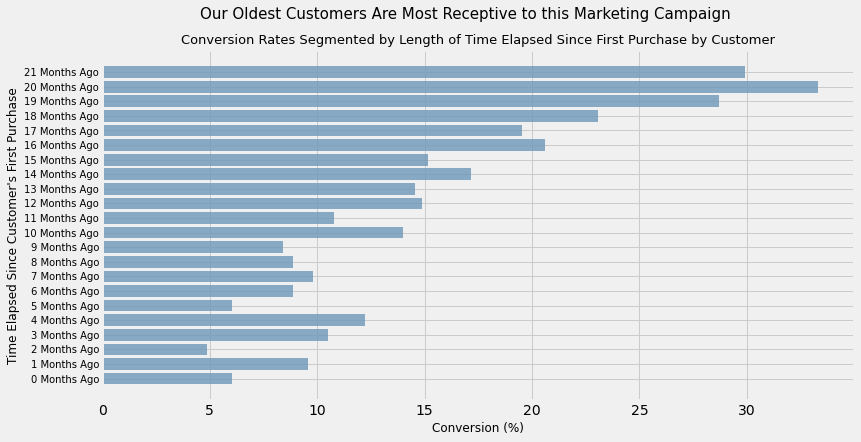

In [232]:
plt.figure(figsize = (12, 6))
plt.barh(time_elapsed_conv_rate['Time Elapsed Bins'],
        time_elapsed_conv_rate['Conversion %'],
        color = '#6D98BA',
        alpha = 0.8)

plt.suptitle('Our Oldest Customers Are Most Receptive to this Marketing Campaign', size = 15)
plt.title('Conversion Rates Segmented by Length of Time Elapsed Since First Purchase by Customer', size = 13)
plt.ylabel('Time Elapsed Since Customer\'s First Purchase', size = 12)
plt.xlabel('Conversion (%)', size = 12)
plt.yticks(size = 10)

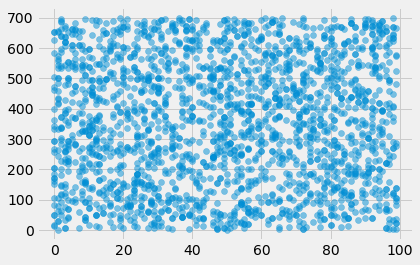

In [235]:
plt.scatter(data['Recency'], data['Days Elapsed'], alpha = 0.5)

# 3) Clustering Analysis

In [233]:
data_clustering = data.loc[:, ['Income', 'Kidhome', 'Teenhome', 'Recency', '']]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Complain,Z_CostContact,Z_Revenue,Response,Profit,Income Deciles,Age,Age Bins,Days Elapsed,Time Elapsed Bins
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,3,11,1,8,"(51382.0, 58482.0]",63,"(60, 70]",664,20 Months Ago
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,3,11,0,-3,"(44529.0, 51382.0]",66,"(60, 70]",114,3 Months Ago
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,3,11,0,-3,"(65248.0, 71819.0]",55,"(50, 60]",313,9 Months Ago
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,3,11,0,-3,"(24118.0, 32011.0]",36,"(30, 40]",140,4 Months Ago
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,3,11,0,-3,"(51382.0, 58482.0]",39,"(30, 40]",162,5 Months Ago
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,...,0,3,11,0,-3,"(58482.0, 65248.0]",53,"(50, 60]",382,11 Months Ago
2236,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,...,0,3,11,0,-3,"(58482.0, 65248.0]",74,"(70, 80]",20,0 Months Ago
2237,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,...,0,3,11,0,-3,"(51382.0, 58482.0]",39,"(30, 40]",156,4 Months Ago
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,...,0,3,11,0,-3,"(65248.0, 71819.0]",64,"(60, 70]",157,4 Months Ago


In [236]:
data.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Profit', 'Income Deciles', 'Age', 'Age Bins', 'Days Elapsed',
       'Time Elapsed Bins'],
      dtype='object')

In [264]:
data_clustering = data.drop(['ID', 'Year_Birth', 'Dt_Customer',
                             'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                             'AcceptedCmp4', 'AcceptedCmp5', 'Z_CostContact',
                             'Z_Revenue', 'Income Deciles', 'Age Bins',
                             'Time Elapsed Bins', 'Profit'], axis = 1)

In [265]:
data_clustering

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Age,Days Elapsed
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,88,3,8,10,4,7,0,1,63,664
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,6,2,1,1,2,5,0,0,66,114
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,...,42,1,8,2,10,4,0,0,55,313
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,...,5,2,2,0,4,6,0,0,36,140
4,PhD,Married,58293.0,1,0,94,173,43,118,46,...,15,5,5,3,6,5,0,0,39,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,Graduation,Married,61223.0,0,1,46,709,43,182,42,...,247,2,9,3,4,5,0,0,53,382
2236,PhD,Together,64014.0,2,1,56,406,0,30,0,...,8,7,8,2,5,7,0,0,74,20
2237,Graduation,Divorced,56981.0,0,0,91,908,48,217,32,...,24,1,2,3,13,6,0,0,39,156
2238,Master,Together,69245.0,0,1,8,428,30,214,80,...,61,2,6,5,10,3,0,0,64,157


In [266]:
# create dummies for "marital_status" variable, then concatenate to dataframe

marital_status_dummies = pd.get_dummies(data['Marital_Status'])
data_clustering = pd.concat([data_clustering, marital_status_dummies], axis = 1)

# and drop original "marital_status" variable

data_clustering.drop('Marital_Status', axis = 1, inplace = True)

data_clustering.drop(['Absurd', 'YOLO'], axis = 1, inplace = True) # drop irrelevant dummies

In [267]:
# do the same as above for "Education" variable

education_dummies = pd.get_dummies(data['Education'])
data_clustering = pd.concat([data_clustering, education_dummies], axis = 1)
data_clustering.drop('Education', axis = 1, inplace = True)

# Ensure I got the following right

In [268]:
# place outcome variable, Response, at the end of the dataframe

response_variable = data_clustering['Response']
data_clustering.drop('Response', axis = 1, inplace = True)
data_clustering['Response'] = response_variable

## Correlation heatmap

<AxesSubplot:>

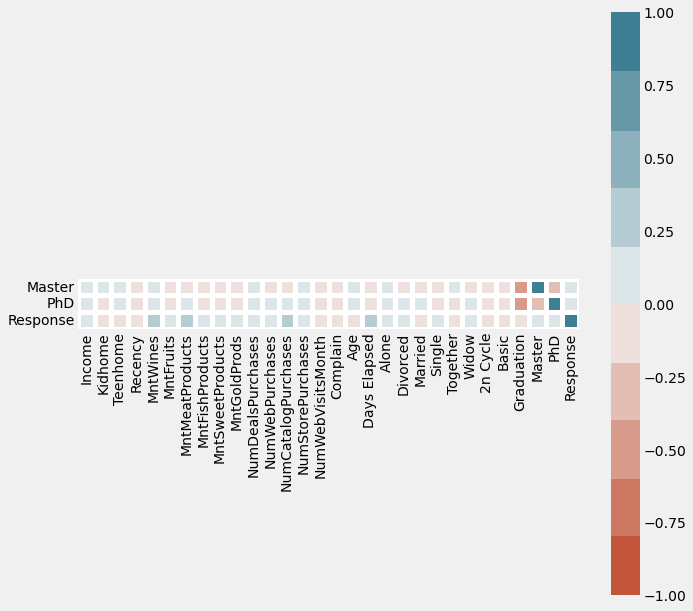

In [310]:
plt.figure(figsize = (10, 10))

sns.heatmap(corr,
            vmin = -1, vmax = 1, center = 0, #annot=True,
            cmap = sns.diverging_palette(20, 220, n= 10),
            square = True, linewidths= 5)

In [290]:
corr = data_clustering.corr()
corr = corr.iloc[-3:, :] # drop all rows but the last
corr

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Married,Single,Together,Widow,2n Cycle,Basic,Graduation,Master,PhD,Response
Master,0.011827,0.013027,0.023532,-0.026004,0.036722,-0.055592,-0.008071,-0.049846,-0.067272,-0.032370,...,-0.007888,-0.007669,0.021174,-0.010148,-0.139866,-0.070180,-0.447279,1.000000,-0.233812,0.003919
PhD,0.081552,-0.043844,0.092342,-0.008248,0.159450,-0.082192,0.006439,-0.103501,-0.085676,-0.117515,...,0.008949,-0.016681,-0.020936,0.045134,-0.165841,-0.083213,-0.530345,-0.233812,1.000000,0.087979
Response,0.133047,-0.077909,-0.153901,-0.199766,0.246299,0.122443,0.237746,0.108145,0.116170,0.140332,...,-0.079821,0.108726,-0.075293,0.045656,-0.035496,-0.050080,-0.039660,0.003919,0.087979,1.000000
